In [36]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas import DataFrame, concat
from google.colab import drive
drive.mount('/content/drive')
from datetime import date
import lightgbm as lgbm
from lightgbm import LGBMRegressor
import time
import statsmodels.api as sm
from sklearn import linear_model, metrics
from sklearn.model_selection import train_test_split
from tqdm import tnrange, tqdm_notebook
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.regression.quantile_regression import QuantReg
from sklearn.ensemble import GradientBoostingRegressor
import os
import math
from math import radians
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
#### 파라미터 ####

# 하루의 틱
ticks = 48

# 예측에 사용할 일수
days = 3                # 이 부분을 바꿀 수 있다.
n_days = ticks*days

# 미래 예측할 일수
future_days = 3
future_window = ticks * future_days

### 모든변수
# ['Hour', 'Minute', 'Day', 'WS', 'Time', 'DHI','DNI','RH','T','TARGET']

# 사용할 변수
what_to_left = ['Time', 'WS', 'DHI','DNI','RH','T','TARGET', 'Day']

n_features = len(what_to_left)
n_obs = n_days * n_features # 7일 예측 기준으로 7(일 수) * 48(틱 수) * 6(변수 개수)

In [38]:
def 절기24(Date):
  target = 0
  for i in list24:
    if Date < i:
      target = list24.index(i) - 1
      break
  if Date < 5:
    target = 23
  return target

def get_yday(when):
  HP = date(2020,1,1)
  results = (when-HP).days
  return results

def drop_clms(dataset):
  dataset['Time'] = dataset['Hour'] + dataset['Minute']*(0.5/30)
  dataset['Date'] = dataset['Day']%365
  dataset.drop('Day', axis=1, inplace=True)

  return dataset

소한 = get_yday(date(2020,1,6))
대한 = get_yday(date(2020,1,20))
입춘 = get_yday(date(2020,2,4))
우수 = get_yday(date(2020,2,19))
경칩 = get_yday(date(2020,3,6))
춘분 = get_yday(date(2020,3,21))
청명 = get_yday(date(2020,4,5))
곡우 = get_yday(date(2020,4,20))
입하 = get_yday(date(2020,5,6))
소만 = get_yday(date(2020,5,21))
망종 = get_yday(date(2020,6,6))
하지 = get_yday(date(2020,6,22))
소서 = get_yday(date(2020,7,7))
대서 = get_yday(date(2020,7,23))
입추 = get_yday(date(2020,8,8))
처서 = get_yday(date(2020,8,23))
백로 = get_yday(date(2020,9,8))
추분 = get_yday(date(2020,9,23))
한로 = get_yday(date(2020,10,8))
상강 = get_yday(date(2020,10,24))
입동 = get_yday(date(2020,11,8))
소설 = get_yday(date(2020,11,22))
대설 = get_yday(date(2020,12,7))
동지 = get_yday(date(2020,12,22))

list24 = [소한, 대한, 입춘, 우수, 경칩, 춘분, 청명, 곡우, 입하, 소만, 망종, 하지, 소서, 대서, 입추, 처서, 백로, 추분, 한로, 상강, 입동, 소설, 대설, 동지]

In [39]:
# 데이터 불러오기 

raw_data = pd.read_csv('/content/drive/MyDrive/Jupyter/unlimited_power/raw_data/train/train.csv')
submission = pd.read_csv('/content/drive/MyDrive/Jupyter/unlimited_power/raw_data/sample_submission.csv')
submission.shape

(7776, 10)

In [40]:
df_test = []

# 예시 코드
# 아직 유진이 어떻게 변수 추가할 지 몰라서 to_supervised는 쓰지 않았음.

for i in range(81):
    file_path = '/content/drive/MyDrive/Jupyter/unlimited_power/raw_data/test/' + str(i) + '.csv'
    new_path = '/content/drive/MyDrive/Jupyter/unlimited_power/raw_data/test/adj_test/' + str(i) + '.csv'
    file_name = str(i) + '.csv'

    
    # adj_test에서 가져와야 하므로 new_path에서 불러온다
    temp = pd.read_csv(new_path)
    temp.drop('Unnamed: 0', axis = 1, inplace = True)
    testset = temp.copy()

    # 24로 저장한 24절기 season으로 이름 바꾸기
    testset.rename(columns = {'24' : 'season', 'T' : 'Temp'}, inplace = True)

    # 이 다음은 trainset과 동일한 전처리, season은 이미 구해져 있으므로 구하지 않음
    testset2 = drop_clms(testset)
    testset2.drop(['Hour', 'Minute','Date'], axis=1,inplace=True)
    df_test.append(testset2)
X_test = pd.concat(df_test)
# X_test = X_test.iloc[:, :n_obs]
X_test 

,DHI,DNI,WS,RH,Temp,TARGET,Time,season
0,0,0,2.7,34.42,0.0,0.0,0.0,22
1,0,0,2.7,34.17,0.1,0.0,0.5,22
2,0,0,2.7,34.23,0.2,0.0,1.0,22
3,0,0,2.7,33.99,0.3,0.0,1.5,22
4,0,0,2.8,33.97,0.4,0.0,2.0,22
...,...,...,...,...,...,...,...,...
331,0,0,0.8,63.35,13.7,0.0,21.5,9
332,0,0,0.7,64.82,13.1,0.0,22.0,9
333,0,0,0.7,66.10,12.8,0.0,22.5,9
334,0,0,0.6,67.64,12.4,0.0,23.0,9


In [41]:
dataset = raw_data.copy()
dataset2 = drop_clms(dataset)
dataset2.drop(['Hour', 'Minute'], axis =1, inplace=True)
dataset2.rename(columns = {'T' : 'Temp'}, inplace = True)
dataset2['season'] = dataset2.apply(lambda x: 절기24(x['Date']), axis = 1)
dataset2.drop('Date', axis = 1, inplace=True)

In [42]:
data = pd.concat([dataset2, X_test], axis = 0)
data

,DHI,DNI,WS,RH,Temp,TARGET,Time,season
0,0,0,1.5,69.08,-12.0,0.0,0.0,23
1,0,0,1.5,69.06,-12.0,0.0,0.5,23
2,0,0,1.6,71.78,-12.0,0.0,1.0,23
3,0,0,1.6,71.75,-12.0,0.0,1.5,23
4,0,0,1.6,75.20,-12.0,0.0,2.0,23
...,...,...,...,...,...,...,...,...
331,0,0,0.8,63.35,13.7,0.0,21.5,9
332,0,0,0.7,64.82,13.1,0.0,22.0,9
333,0,0,0.7,66.10,12.8,0.0,22.5,9
334,0,0,0.6,67.64,12.4,0.0,23.0,9


In [43]:
sunrise = []
sunset = []

for i in range(1, len(data)-1):
  bf = data.iloc[i-1, 5]
  now = data.iloc[i,5]
  aft = data.iloc[i+1, 5]
  if bf == 0 and now > 0:
    sunrise.append(now)
  elif now > 0 and aft ==0:
    sunset.append(now)

In [44]:
sunrise = np.array(sunrise)
sunset = np.array(sunset)

In [45]:
일출_평균 = np.mean(sunrise)
일출_편차 = np.std(sunrise)

일몰_평균 = np.mean(sunset)
일몰_편차 = np.std(sunset)

In [46]:
print('일출평균 : ', 일출_평균)
print('일출편차 : ', 일출_편차)
print('일몰평균 : ', 일몰_평균)
print('일몰편차 : ', 일몰_편차)

일출평균 :  2.578515990533093
일출편차 :  2.043211323970613
일몰평균 :  2.3362615058898917
일몰편차 :  2.0228391738905835


In [47]:
sunrise_percentile = []
sunset_percentile = []

for i in range(1,10):
  k = np.percentile(sunrise, i*10)
  p = np.percentile(sunset, i*10)
  sunrise_percentile.append(k)
  sunset_percentile.append(p)

In [48]:
sunrise_percentile

[0.281543633,
 0.7506427529999999,
 1.2198655353999999,
 1.6328729304000085,
 2.064653305,
 2.6275846264,
 3.2842786329999996,
 4.222783193,
 5.724204634200001]

In [49]:
sunset_percentile

[0.1876877513,
 0.469131093,
 0.8444631654000001,
 1.313742642,
 1.782776538,
 2.3460009762,
 3.0967110782000002,
 4.1284353048,
 5.536020729400001]

시각 :  4.5
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


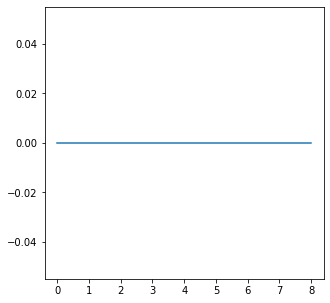

시각 :  5.0
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.375331113, 2.3459354842]


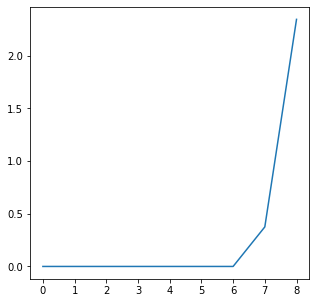

시각 :  5.5
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.595400943, 4.973806317, 8.810595488000008]


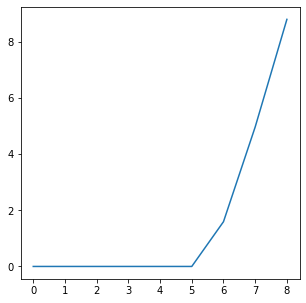

시각 :  6.0
[0.0, 0.0, 0.0, 0.0, 0.37537624550000004, 3.0968846586, 7.224720486399999, 12.01021276, 16.983060806999998]


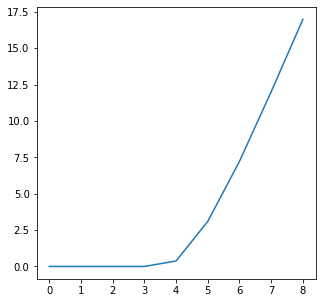

시각 :  6.5
[0.0, 0.0, 0.0, 1.2199052224, 4.316712961, 9.3833231978, 14.637339001, 20.456723804, 26.177457449]


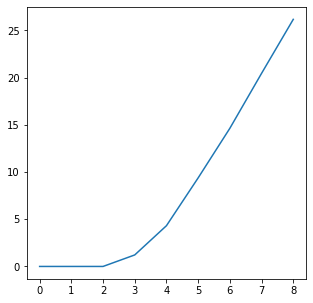

시각 :  7.0
[0.0, 0.0, 1.7830371667999998, 5.8183330864, 10.837818845000001, 17.265276732, 23.269690028, 29.273162374, 35.469230691]


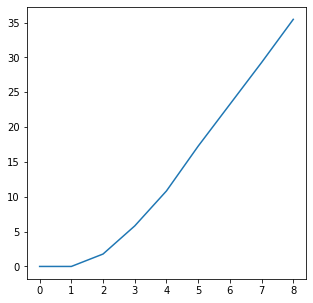

시각 :  7.5
[1.1262051, 2.9088711164000003, 6.5680049651, 12.104848812, 18.6263931, 25.521932148, 32.531871004999985, 38.82417929800002, 45.025617714000006]


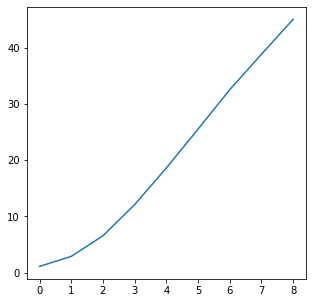

시각 :  8.0
[5.4429830791, 8.371391155400005, 12.857147913, 18.582255494, 26.55646836, 34.34590727, 41.846723502, 48.11112280000001, 53.952625782]


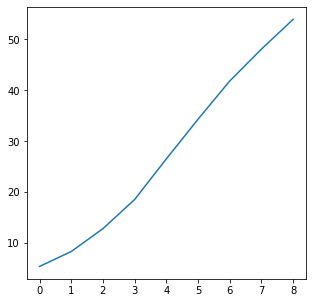

시각 :  8.5
[9.477968946399999, 15.128076530000005, 19.454074338999995, 26.50007826000001, 35.000834225000006, 42.66005733799999, 50.36007028799998, 56.36915490400001, 62.30177338000001]


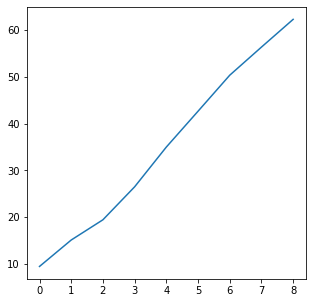

시각 :  9.0
[12.677721284000004, 21.321393694000005, 26.465188712, 33.406172696, 42.225813005, 50.480125868, 58.23696327399998, 64.182495036, 69.885555456]


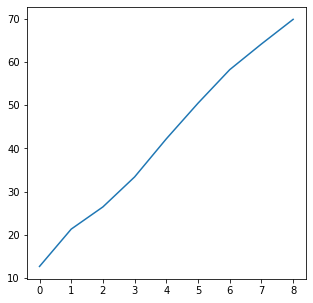

시각 :  9.5
[15.680473372000002, 26.272473252, 32.498875784999996, 40.01154508600001, 48.551839779999995, 57.197969091999994, 64.33288792799998, 70.72029381800002, 76.839052563]


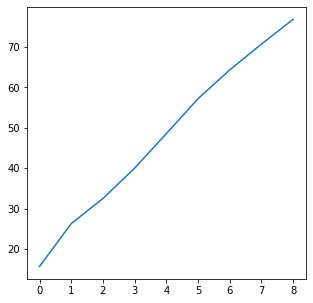

시각 :  10.0
[17.943417452000006, 31.437933328, 37.752797484, 44.98701336000001, 53.673582100000004, 61.89152313999999, 69.02756856499998, 75.787653246, 82.26906616100001]


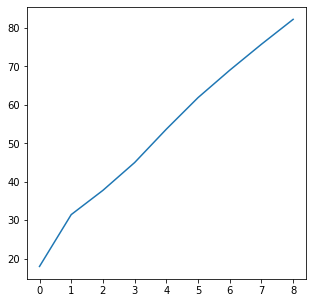

시각 :  10.5
[19.332280335, 35.20854782400001, 41.879240069, 48.27077960800001, 56.02182601, 65.453396064, 72.19481082899996, 79.17136564400002, 86.02153205300002]


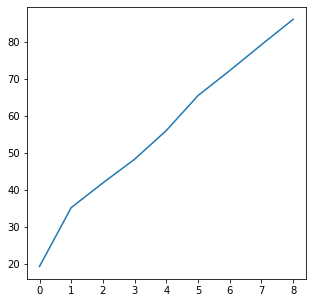

시각 :  11.0
[21.407805356, 35.088922798, 44.948983479, 50.855934716, 58.18143169, 66.02004582199999, 73.837865537, 81.69620002000002, 89.030285587]


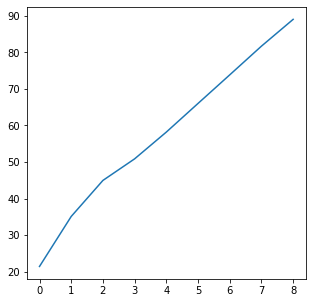

시각 :  11.5
[21.321320362000005, 35.97597022000001, 45.510017899000005, 51.238102936, 58.450457215, 67.72331347799997, 75.636102272, 82.61864071200003, 90.345292455]


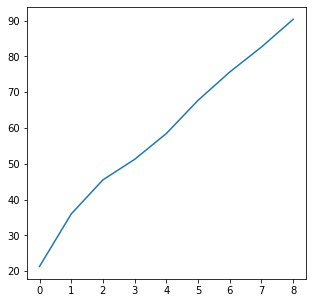

시각 :  12.0
[20.657220055000003, 35.37178453, 45.069682166999996, 50.854738442, 58.22447704, 66.489494374, 75.897868049, 83.00794711600001, 90.909600635]


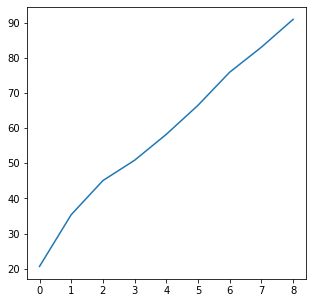

시각 :  12.5
[19.984589138999997, 33.97293166, 43.166512851, 49.354164258, 55.45099044, 65.024428476, 73.52683711999998, 81.914610732, 90.073466916]


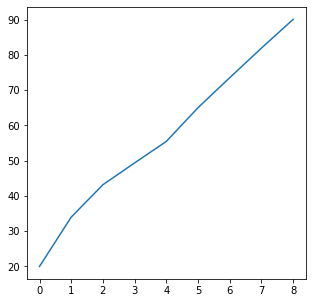

시각 :  13.0
[17.744732756, 30.704326620000003, 40.819968341, 46.167594226000006, 52.87775441, 62.106975666, 70.80418687099998, 79.16429664400002, 87.641587292]


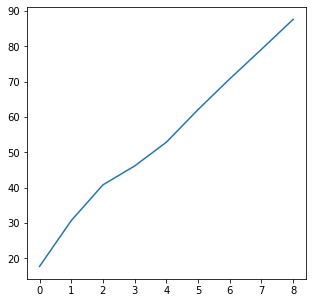

시각 :  13.5
[14.732902318999999, 26.739637516000002, 36.249303268999995, 42.511406542, 48.505755535, 57.29272507199999, 66.89850569, 75.03824917600002, 83.41604697700001]


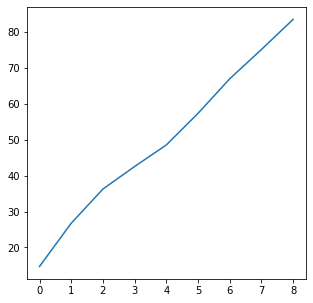

시각 :  14.0
[13.134295988, 24.680093022, 33.059624709999994, 38.135915538000006, 44.244895535, 52.447587826, 61.42407072999998, 69.33147807, 78.067206719]


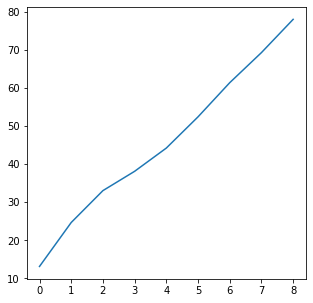

시각 :  14.5
[10.332805400000002, 20.551343494, 28.340859822, 32.84513271, 38.564483385, 46.821088783999954, 54.898341513000005, 63.405664234000014, 71.86906639]


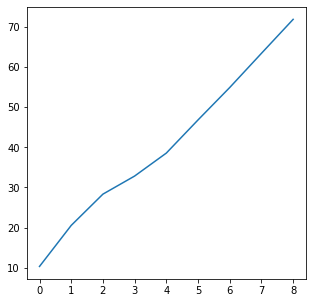

시각 :  15.0
[8.4456777733, 17.170122516, 22.523304956, 26.745492834, 32.697357339999996, 39.657885095999994, 48.01630955599998, 55.43062695600002, 64.915720035]


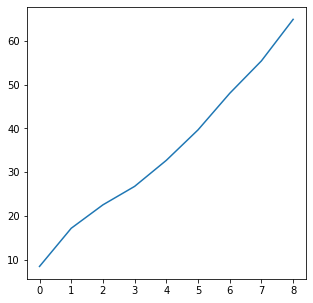

시각 :  15.5
[6.7554810573, 12.667291384, 16.234665769, 20.269136548, 25.760817959999997, 32.42618879999999, 40.536522063999996, 48.03465156199999, 57.030411722000004]


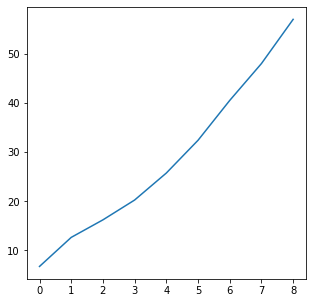

시각 :  16.0
[4.326172729900002, 7.0384175417999995, 9.853318892399999, 14.074149382, 19.095526005, 26.086980347999997, 32.747114055000004, 39.87843102, 49.068399115999995]


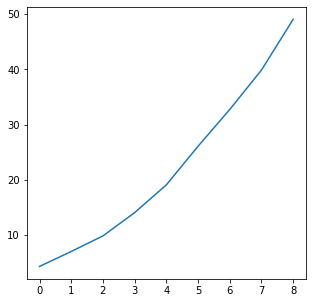

시각 :  16.5
[0.84444525, 2.2524302496, 4.720232946799996, 8.577350699000007, 13.605766294999999, 19.328430496, 24.928954139999984, 32.163483350000014, 40.249969974]


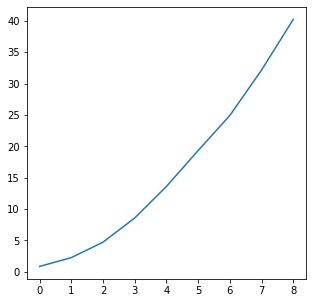

시각 :  17.0
[0.0, 0.0, 1.2200063181, 3.8472174833999997, 7.4603286915, 11.973677423999991, 16.702041748, 22.987777328, 30.211819891]


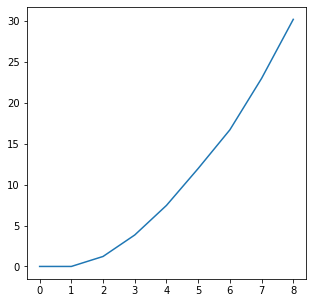

시각 :  17.5
[0.0, 0.0, 0.0, 0.5629350341999999, 2.8153017305, 6.005340048000001, 9.9452643162, 14.825435552, 21.674316322000003]


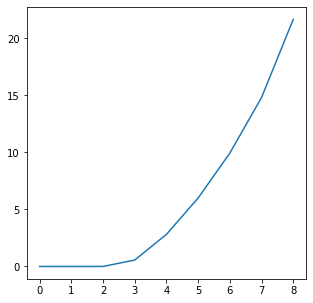

시각 :  18.0
[0.0, 0.0, 0.0, 0.0, 0.28147092100000004, 1.876524373, 4.663472065499983, 8.9136867304, 14.346843314000008]


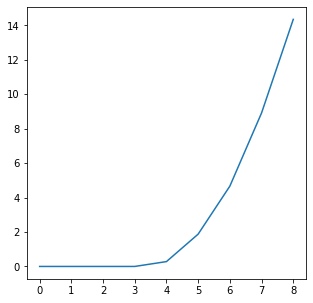

시각 :  18.5
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9383454184, 3.5657027914, 7.309328690600009]


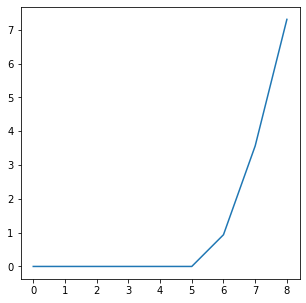

시각 :  19.0
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.281498644, 2.2519341999]


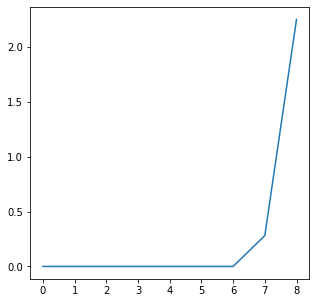

시각 :  19.5
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


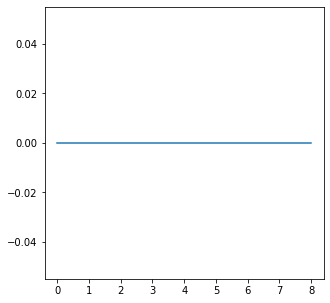

In [73]:
times = list(set(data.Time)-set([0,0.5,1,1.5,2,2.5,3,3.5,4,20, 20.5, 21,21.5,22,22.5,23,23.5]))
times = sorted(times)

for i in times:
  dataset = np.array(data[data.Time == i].TARGET)
  time_percentile = []
  for j in range(1,10):
    k = np.percentile(dataset, j*10)
    time_percentile.append(k)
  print('시각 : ', i)
  print(time_percentile)
  plt.figure(figsize=(5, 5))
  plt.plot(time_percentile)
  plt.show()

In [72]:
season = list(set(data.season))

for m in season:
  datas = data[data.season == m]
  print('##########################################################################################')
  print('절기 : ', m)
  for i in times:
    dataset = np.array(datas[datas.Time == i].TARGET)
    time_percentile = []
    for j in range(1,10):
      k = np.percentile(dataset, j*10)
      time_percentile.append(k)
    print('시간 : ', i,'시', ' & 절기 : ',m)
    print(time_percentile)
    plt.figure(figsize=(5, 5))
    plt.plot(time_percentile)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

<Figure size 1440x1440 with 0 Axes>

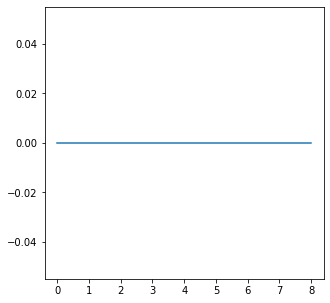

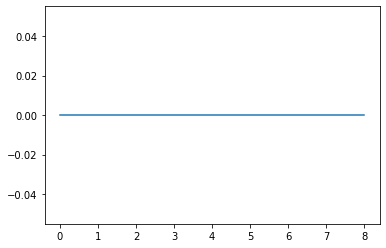

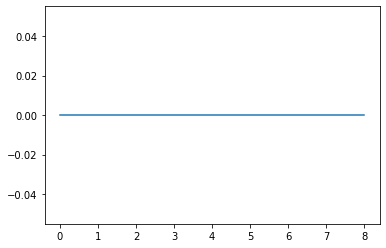

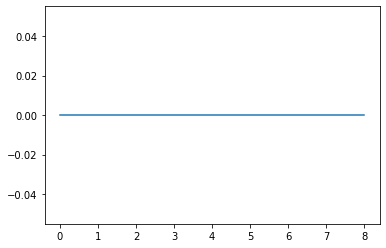

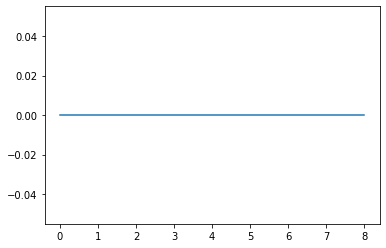

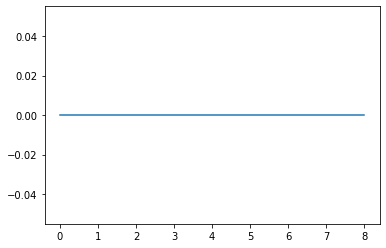

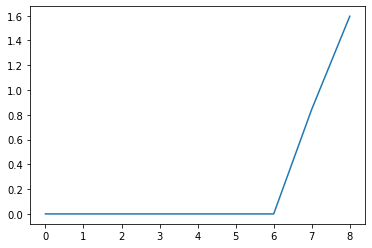

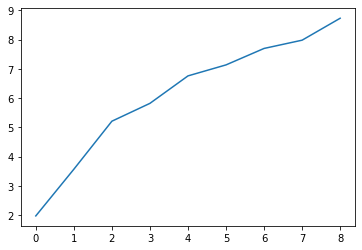

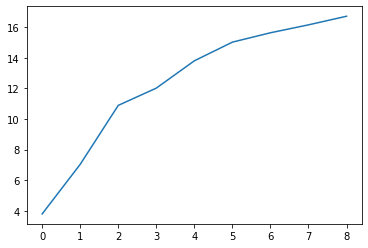

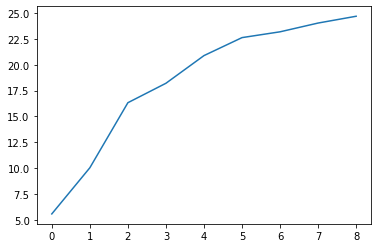

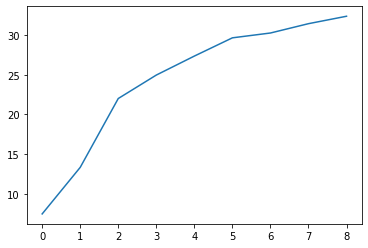

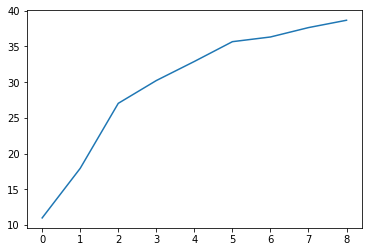

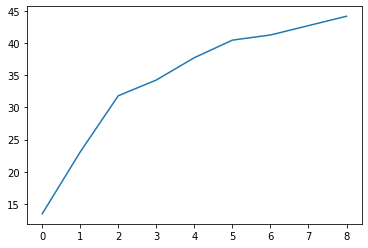

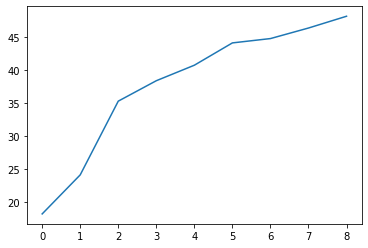

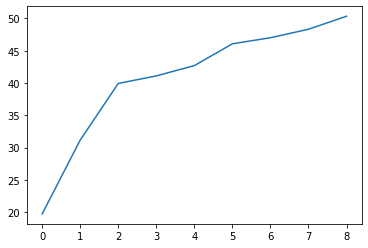

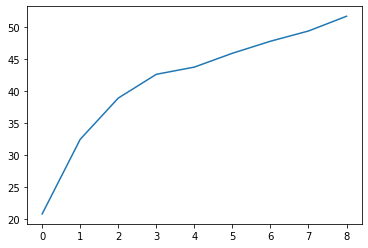

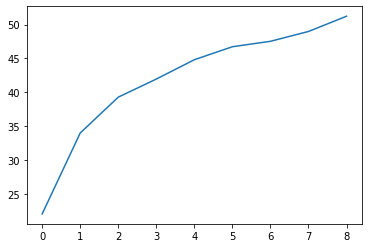

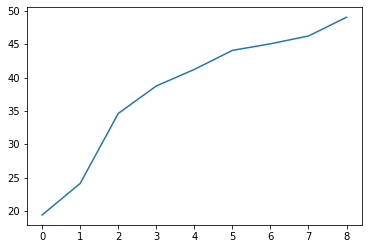

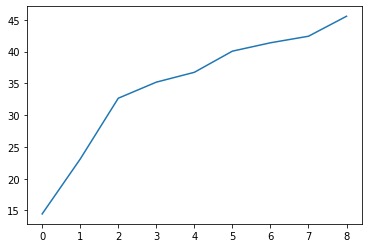

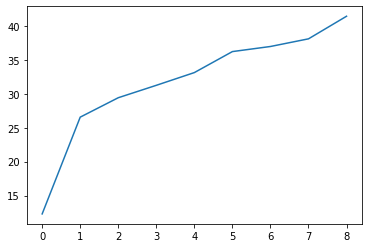

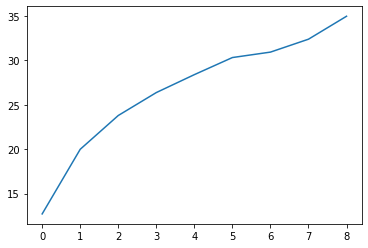

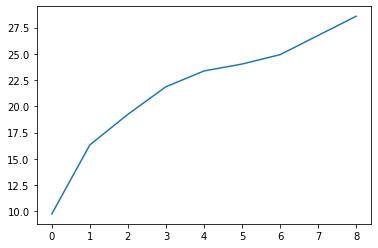

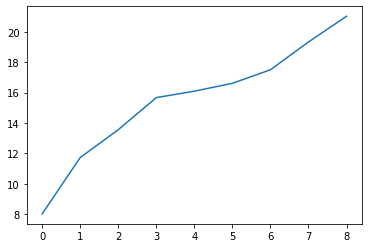

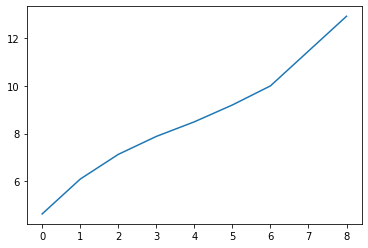

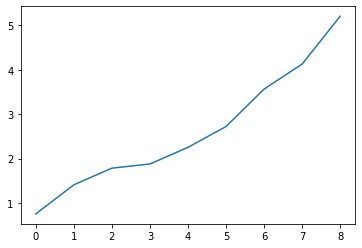

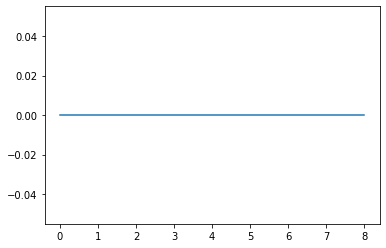

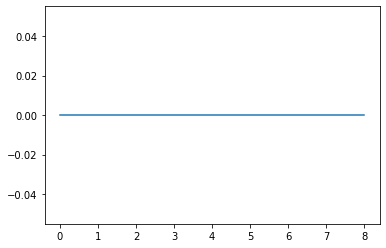

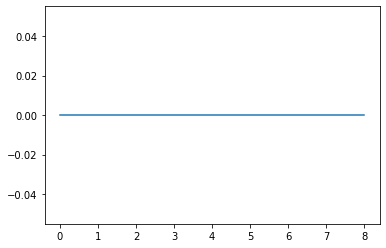

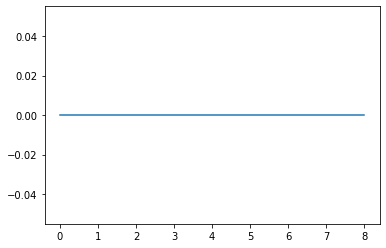

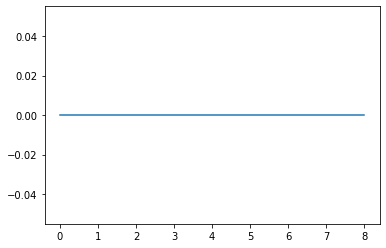

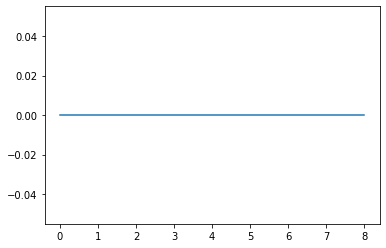

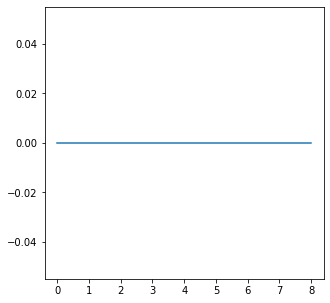

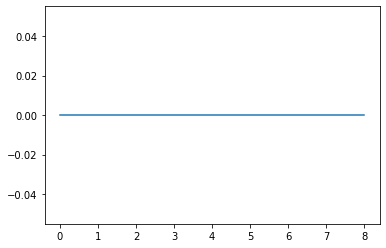

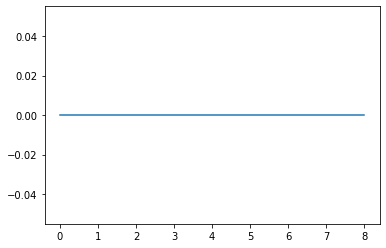

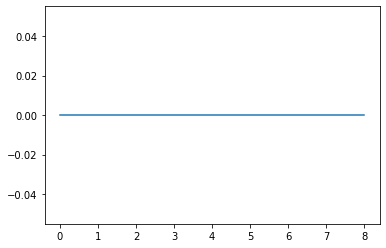

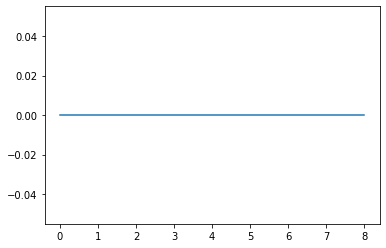

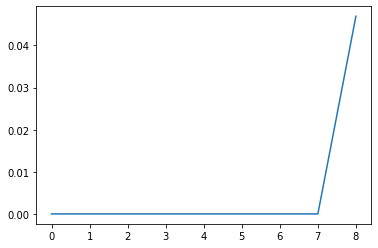

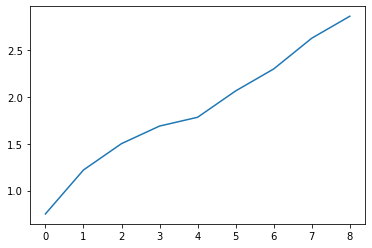

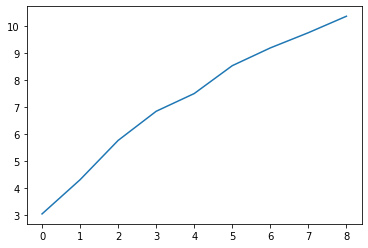

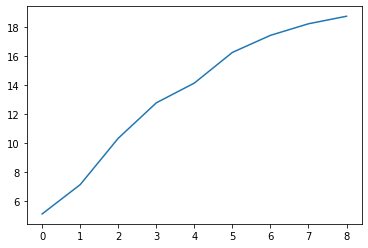

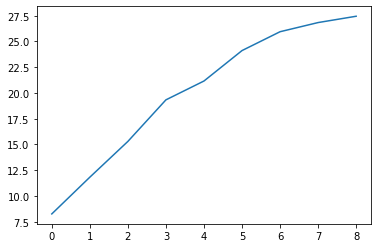

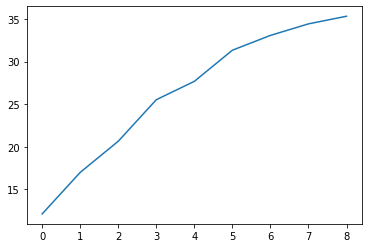

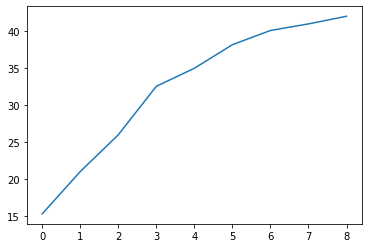

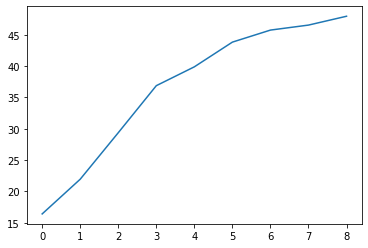

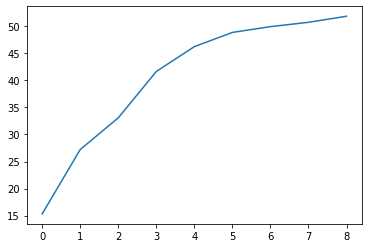

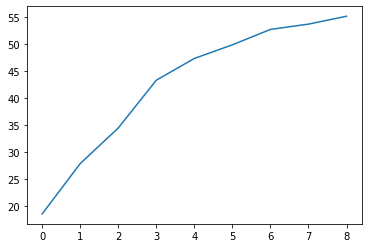

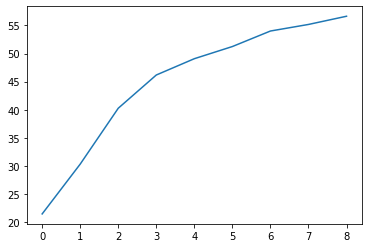

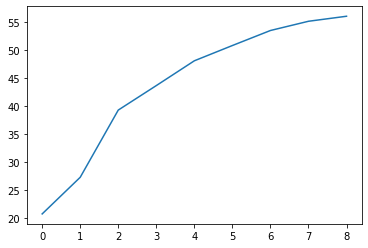

KeyboardInterrupt: ignored

In [81]:
plt.figure(figsize=(20, 20))

for m in season:
  datas = data[data.season == m]
  plt.figure(figsize=(5, 5))
  for i in times:
    dataset = np.array(datas[datas.Time == i].TARGET)
    time_percentile = []
    for j in range(1,10):
      k = np.percentile(dataset, j*10)
      time_percentile.append(k)
    plt.plot(time_percentile)
    plt.show()